# Contents

In this notebook, we will implement the TRPO algorithm and train it on a gym environment.

We will implement the algorithm ourselves using Pytorch and Numpy and we'll train it on the [Acrobot](https://www.gymlibrary.dev/environments/classic_control/acrobot/) environment

This notebook is heavily inspired from [This Implementation](https://gist.github.com/elumixor/c16b7bdc38e90aa30c2825d53790d217)

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.distributions import Categorical
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### Initializing the environment

In [2]:
# You can ignore the warning. It happens because we're using gym instead of gymnasium.
# And in gym, the newer api returns 2 bools(terminated and truncated) instead of just 1 and it warns us that we're using the old api
env_name = 'Acrobot-v1'
env = gym.make(env_name)

state_size = env.observation_space.shape[0]
num_actions = env.action_space.n

Rollout = namedtuple('Rollout', ['states', 'actions', 'rewards', 'next_states', ])

print(state_size)
print(num_actions)

6
3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Implementing the model

In [3]:
actor_hidden = 32
actor = nn.Sequential(nn.Linear(state_size, actor_hidden),
                      nn.ReLU(),
                      nn.Linear(actor_hidden, num_actions),
                      nn.Softmax(dim=1))

def get_action(state):
    state = torch.tensor(state).float().unsqueeze(0)  # Turn state into a batch with a single element
    dist = Categorical(actor(state))  # Create a distribution from probabilities for actions
    return dist.sample().item()

In [4]:
# Critic takes a state and returns its values
critic_hidden = 32
critic = nn.Sequential(nn.Linear(state_size, critic_hidden),
                       nn.ReLU(),
                       nn.Linear(critic_hidden, 1))
critic_optimizer = Adam(critic.parameters(), lr=0.005)


def update_critic(advantages):
    loss = .5 * (advantages ** 2).mean()  # MSE
    critic_optimizer.zero_grad()
    loss.backward()
    critic_optimizer.step()

In [5]:
# Helper functions
def estimate_advantages(states, last_state, rewards):
    values = critic(states)
    last_value = critic(last_state.unsqueeze(0))
    next_values = torch.zeros_like(rewards)
    for i in reversed(range(rewards.shape[0])):
        last_value = next_values[i] = rewards[i] + 0.99 * last_value
    advantages = next_values - values
    return advantages


def surrogate_loss(new_probabilities, old_probabilities, advantages):
    return (new_probabilities / old_probabilities * advantages).mean()


def kl_div(p, q):
    p = p.detach()
    return (p * (p.log() - q.log())).sum(-1).mean()


def flat_grad(y, x, retain_graph=False, create_graph=False):
    if create_graph:
        retain_graph = True

    g = torch.autograd.grad(y, x, retain_graph=retain_graph, create_graph=create_graph)
    g = torch.cat([t.view(-1) for t in g])
    return g


def conjugate_gradient(A, b, delta=0., max_iterations=10):
    x = torch.zeros_like(b)
    r = b.clone()
    p = b.clone()

    i = 0
    while i < max_iterations:
        AVP = A(p)

        dot_old = r @ r
        alpha = dot_old / (p @ AVP)

        x_new = x + alpha * p

        if (x - x_new).norm() <= delta:
            return x_new

        i += 1
        r = r - alpha * AVP

        beta = (r @ r) / dot_old
        p = r + beta * p

        x = x_new
    return x


def apply_update(grad_flattened):
    n = 0
    for p in actor.parameters():
        numel = p.numel()
        g = grad_flattened[n:n + numel].view(p.shape)
        p.data += g
        n += numel


# delta, maximum KL divergence
max_d_kl = 0.01

def update_agent(rollouts):
    states = torch.cat([r.states for r in rollouts], dim=0)
    actions = torch.cat([r.actions for r in rollouts], dim=0).flatten()

    advantages = [estimate_advantages(states, next_states[-1], rewards) for states, _, rewards, next_states in rollouts]
    advantages = torch.cat(advantages, dim=0).flatten()

    # Normalize advantages to reduce skewness and improve convergence
    advantages = (advantages - advantages.mean()) / advantages.std()

    update_critic(advantages)

    distribution = actor(states)
    distribution = torch.distributions.utils.clamp_probs(distribution)
    probabilities = distribution[range(distribution.shape[0]), actions]

    # Now we have all the data we need for the algorithm

    # We will calculate the gradient wrt to the new probabilities (surrogate function),
    # so second probabilities should be treated as a constant
    L = surrogate_loss(probabilities, probabilities.detach(), advantages)
    KL = kl_div(distribution, distribution)

    parameters = list(actor.parameters())

    g = flat_grad(L, parameters, retain_graph=True)
    d_kl = flat_grad(KL, parameters, create_graph=True)  # Create graph, because we will call backward() on it (for HVP)

    def HVP(v):
        return flat_grad(d_kl @ v, parameters, retain_graph=True)

    search_dir = conjugate_gradient(HVP, g)
    max_length = torch.sqrt(2 * max_d_kl / (search_dir @ HVP(search_dir)))
    max_step = max_length * search_dir

    def criterion(step):
        apply_update(step)

        with torch.no_grad():
            distribution_new = actor(states)
            distribution_new = torch.distributions.utils.clamp_probs(distribution_new)
            probabilities_new = distribution_new[range(distribution_new.shape[0]), actions]

            L_new = surrogate_loss(probabilities_new, probabilities, advantages)
            KL_new = kl_div(distribution, distribution_new)

        L_improvement = L_new - L

        if L_improvement > 0 and KL_new <= max_d_kl:
            return True

        apply_update(-step)
        return False

    i = 0
    while not criterion((0.9 ** i) * max_step) and i < 10:
        i += 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def train(epochs=100, num_rollouts=10, render_frequency=None):
    mean_total_rewards = []
    global_rollout = 0

    for epoch in range(epochs):
        rollouts = []
        rollout_total_rewards = []

        for t in range(num_rollouts):
            state = env.reset()
            done = False

            samples = []

            while not done:
                if render_frequency is not None and global_rollout % render_frequency == 0:
                    env.render()

                with torch.no_grad():
                    action = get_action(state)

                next_state, reward, done, _ = env.step(action)

                # Collect samples
                samples.append((state, action, reward, next_state))

                state = next_state

            # Transpose our samples
            states, actions, rewards, next_states = zip(*samples)

            states = torch.stack([torch.from_numpy(state) for state in states], dim=0).float()
            next_states = torch.stack([torch.from_numpy(state) for state in next_states], dim=0).float()
            actions = torch.as_tensor(actions).unsqueeze(1)
            rewards = torch.as_tensor(rewards).unsqueeze(1)

            rollouts.append(Rollout(states, actions, rewards, next_states))

            rollout_total_rewards.append(rewards.sum().item())
            global_rollout += 1

        update_agent(rollouts)
        mtr = np.mean(rollout_total_rewards)
        print(f'E: {epoch}.\tMean total reward across {num_rollouts} rollouts: {mtr}')

        mean_total_rewards.append(mtr)

    plt.plot(mean_total_rewards)
    plt.show()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


E: 0.	Mean total reward across 20 rollouts: -500.0
E: 1.	Mean total reward across 20 rollouts: -500.0
E: 2.	Mean total reward across 20 rollouts: -500.0
E: 3.	Mean total reward across 20 rollouts: -490.8
E: 4.	Mean total reward across 20 rollouts: -484.0
E: 5.	Mean total reward across 20 rollouts: -500.0
E: 6.	Mean total reward across 20 rollouts: -493.45
E: 7.	Mean total reward across 20 rollouts: -448.4
E: 8.	Mean total reward across 20 rollouts: -466.95
E: 9.	Mean total reward across 20 rollouts: -468.4
E: 10.	Mean total reward across 20 rollouts: -428.65
E: 11.	Mean total reward across 20 rollouts: -421.4
E: 12.	Mean total reward across 20 rollouts: -404.75
E: 13.	Mean total reward across 20 rollouts: -367.5
E: 14.	Mean total reward across 20 rollouts: -359.6
E: 15.	Mean total reward across 20 rollouts: -316.8
E: 16.	Mean total reward across 20 rollouts: -319.2
E: 17.	Mean total reward across 20 rollouts: -270.6
E: 18.	Mean total reward across 20 rollouts: -272.4
E: 19.	Mean total 

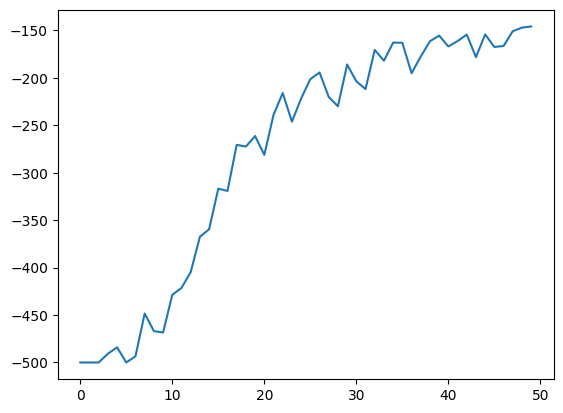

In [7]:
# Train our agent
train(epochs=50, num_rollouts=20, render_frequency=None)

## Visualizing the results

In [8]:
# Helper function to visualize frames as a video
def frames_to_video(frames, fps=24):
    fig = plt.figure(figsize=(frames[0].shape[1] / 100, frames[0].shape[0] / 100), dpi=100)
    ax = plt.axes()
    ax.set_axis_off()

    if len(frames[0].shape) == 2:  # Grayscale image
        im = ax.imshow(frames[0], cmap='gray')
    else:  # Color image
        im = ax.imshow(frames[0])

    def init():
        if len(frames[0].shape) == 2:
            im.set_data(frames[0], cmap='gray')
        else:
            im.set_data(frames[0])
        return im,

    def update(frame):
        if len(frames[frame].shape) == 2:
            im.set_data(frames[frame], cmap='gray')
        else:
            im.set_data(frames[frame])
        return im,

    interval = 1000 / fps
    anim = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=True, interval=interval)
    plt.close()
    return HTML(anim.to_html5_video())

In [9]:
test_env = gym.make(env_name, render_mode='rgb_array')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [10]:
test_env.reset()
sample = test_env.render()
print(len(sample))
print(type(sample))

1
<class 'list'>


In [13]:
state = test_env.reset()
frames = []

while True:
    with torch.no_grad():
        action = get_action(state)
    state_next, r, done, info = test_env.step(action)
    frames.append(test_env.render()[0])
    state = state_next
    if done:
        break

In [14]:
frames_to_video(frames)